In [91]:
# -----------------------------
# Task 3 | Time-Series Model
# -----------------------------
# D1 to D5: Data Cleaning and Preprocessing
# -----------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

In [93]:
# -------------------------------------------------
# D1 
# -------------------------------------------------
df = pd.read_csv("medical_clean (1).csv")


In [95]:
# D2) Describe time step formatting and assign Day index
df["Day"] = np.arange(1, len(df) + 1)
df.set_index("Day", inplace=True)

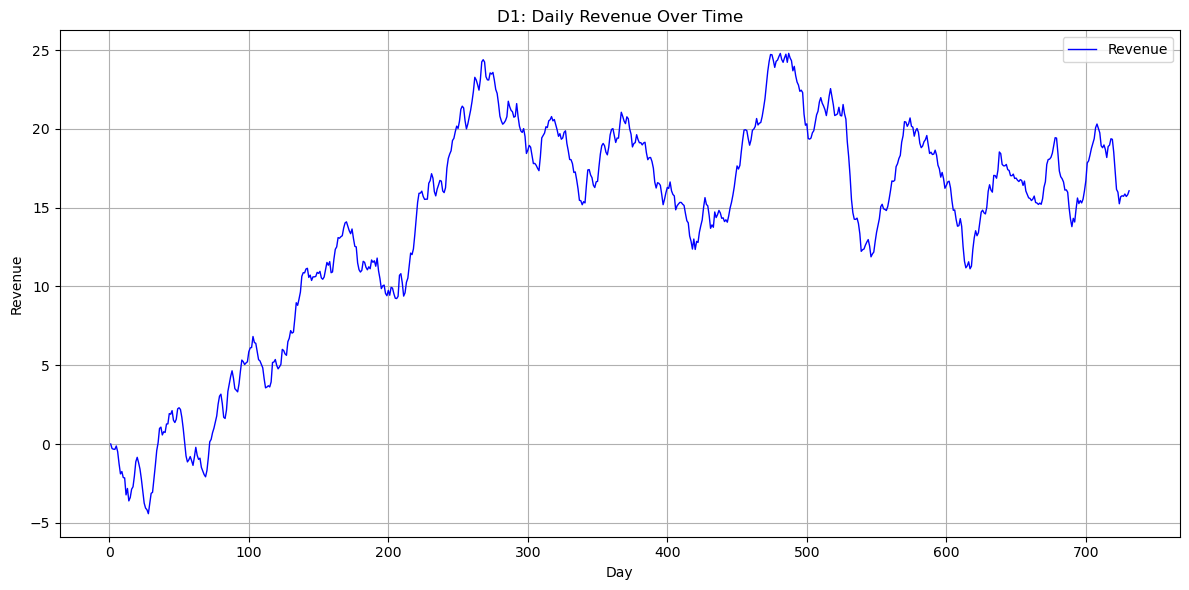

In [97]:
# D1) Line graph of time series
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Revenue'], label='Revenue', color='blue', linewidth=1)
plt.title('D1: Daily Revenue Over Time')
plt.xlabel('Day')
plt.ylabel('Revenue')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [99]:
# D2) Check for gaps and print length
# Gaps = None if difference between every Day is 1
time_index_gap_check = df.index.to_series().diff().dropna().eq(1).all()
sequence_length = len(df)
print(f"D2: Gaps in sequence: {not time_index_gap_check}")
print(f"D2: Length of sequence: {sequence_length}")

D2: Gaps in sequence: False
D2: Length of sequence: 731


In [101]:
# D3) Stationarity check
adf_result = adfuller(df['Revenue'])
print("\nD3: ADF Statistic:", adf_result[0])
print("D3: p-value:", adf_result[1])
print("D3: Critical Values:", adf_result[4])


D3: ADF Statistic: -2.2183190476089436
D3: p-value: 0.199664006150644
D3: Critical Values: {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}


In [103]:
# D4) First-order differencing
df["Revenue_diff"] = df["Revenue"].diff()
df_diff = df["Revenue_diff"].dropna()

# Re-check stationarity after differencing
adf_result_diff = adfuller(df_diff)
print("\nD4: ADF Statistic (Differenced):", adf_result_diff[0])
print("D4: p-value (Differenced):", adf_result_diff[1])
print("D4: Critical Values (Differenced):", adf_result_diff[4])

# D4) Train-test split (80/20)
train_size = int(len(df_diff) * 0.8)
train, test = df_diff[:train_size], df_diff[train_size:]
print(f"\nD4: Training size: {len(train)} | Test size: {len(test)}")



D4: ADF Statistic (Differenced): -17.374772303557066
D4: p-value (Differenced): 5.113206978840171e-30
D4: Critical Values (Differenced): {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}

D4: Training size: 584 | Test size: 146


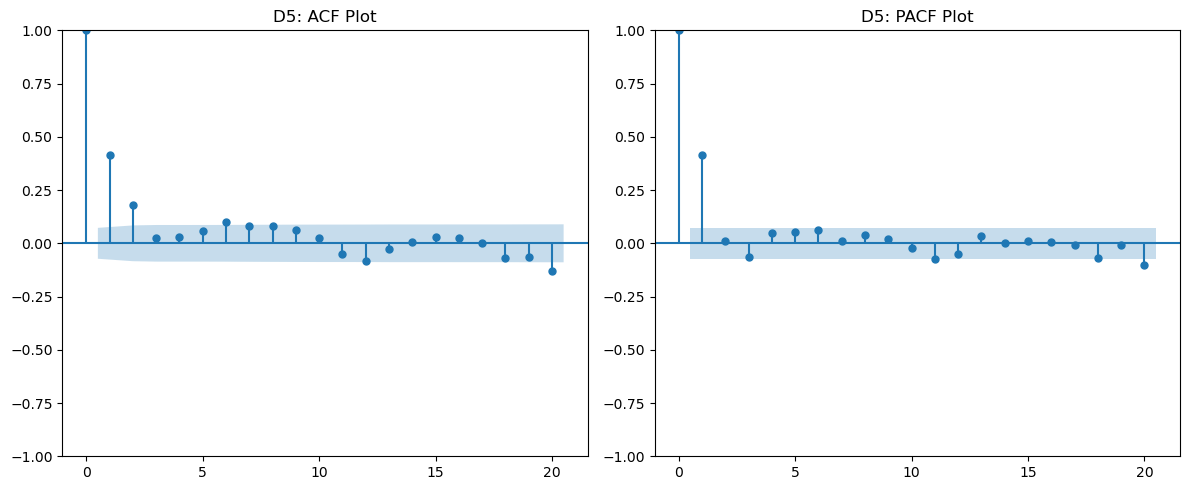

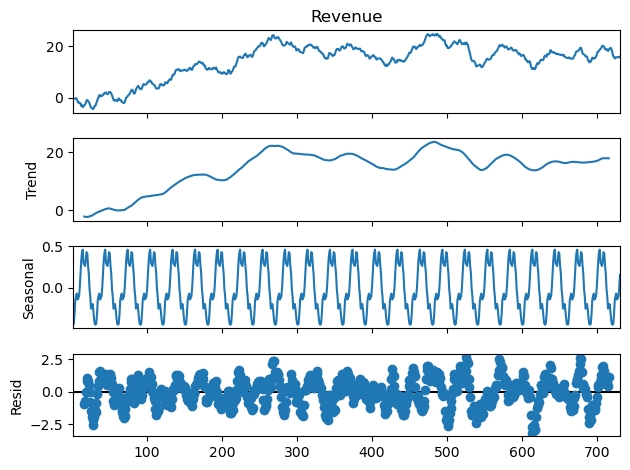

In [105]:
# D5) ACF and PACF plots
plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_acf(df_diff, lags=20, ax=plt.gca())
plt.title("D5: ACF Plot")
plt.subplot(122)
plot_pacf(df_diff, lags=20, ax=plt.gca())
plt.title("D5: PACF Plot")
plt.tight_layout()
plt.show()

# D5) Seasonal decomposition
decomp = seasonal_decompose(df['Revenue'], model='additive', period=30)
decomp.plot()
plt.tight_layout()
plt.show()

# Save cleaned dataset
df.to_csv("cleaned_medical_data.csv")

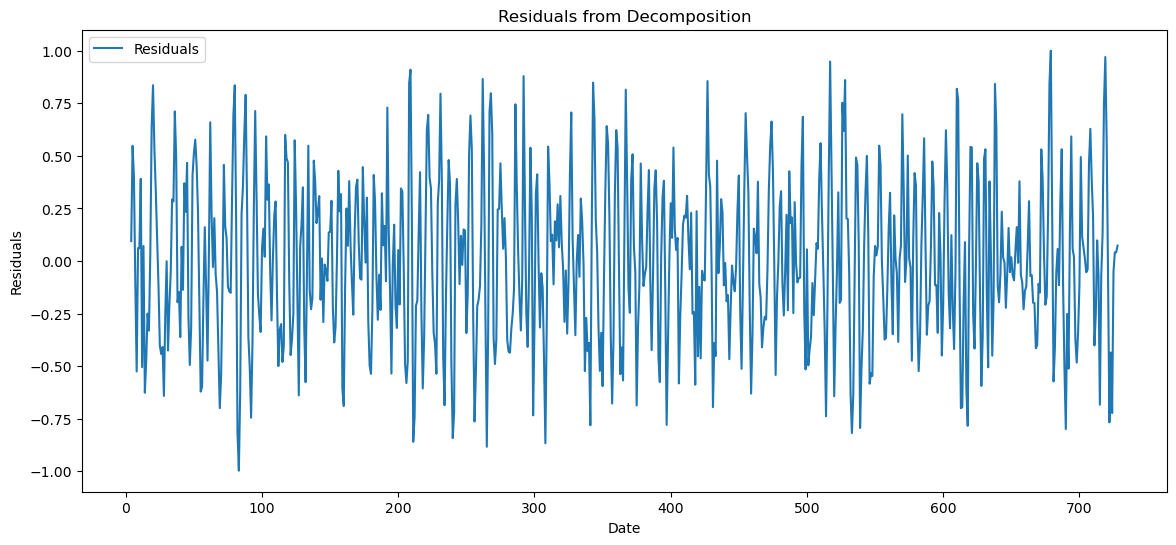

In [107]:
#Showing Residuals from decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Revenue'], model='additive', period=7)

residuals = decomposition.resid

plt.figure(figsize=[14,6])
plt.plot(df.index, residuals, label='Residuals')
plt.title('Residuals from Decomposition')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

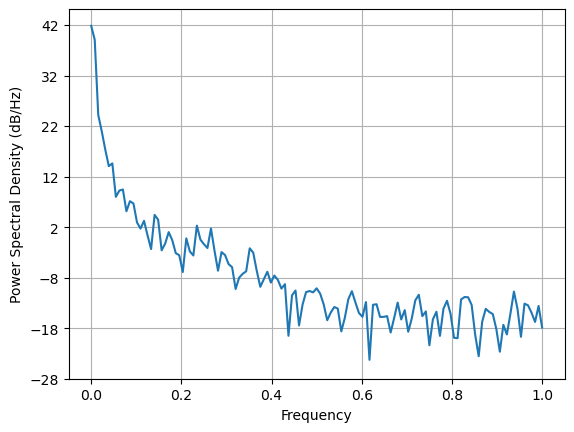

In [109]:
plt.psd(x=df.Revenue);

In [111]:
#Using the train dataset for the ARIMA model with p=1, d=0, q=0
model = ARIMA(train, order=(1, 0, 0))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:           Revenue_diff   No. Observations:                  584
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -350.349
Date:                Thu, 26 Jun 2025   AIC                            706.698
Time:                        03:30:14   BIC                            719.808
Sample:                             0   HQIC                           711.808
                                - 584                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0328      0.031      1.063      0.288      -0.028       0.093
ar.L1          0.4079      0.038     10.748      0.000       0.333       0.482
sigma2         0.1943      0.012     15.948      0.0

C:\Users\marri\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\marri\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\marri\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [113]:
#Forecasting the data using the start of the test set through the end
forecast = results.get_prediction(start=test.index[0], end=test.index[-1])
forecast_mean = forecast.predicted_mean
print(forecast.predicted_mean)

586    0.039159
587    0.035388
588    0.033850
589    0.033223
590    0.032967
         ...   
727    0.032791
728    0.032791
729    0.032791
730    0.032791
731    0.032791
Name: predicted_mean, Length: 146, dtype: float64


C:\Users\marri\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\marri\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [115]:
confidence_intervals = forecast.conf_int()
print(confidence_intervals)

     lower Revenue_diff  upper Revenue_diff
586           -0.904871            0.983190
587           -0.910461            0.981237
588           -0.912301            0.980001
589           -0.912978            0.979424
590           -0.913243            0.979177
..                  ...                 ...
727           -0.913421            0.979002
728           -0.913421            0.979002
729           -0.913421            0.979002
730           -0.913421            0.979002
731           -0.913421            0.979002

[146 rows x 2 columns]


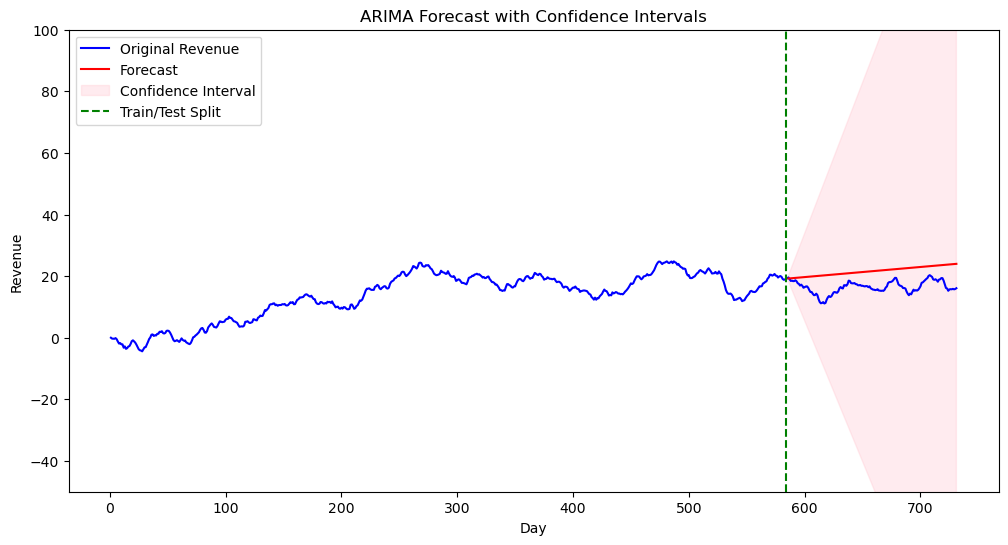

In [117]:
#Using cumulative sum to use the non-differenced predictions
forecast_mean_cumsum = forecast_mean.cumsum() + df['Revenue'].iloc[train_size - 1]
confidence_intervals_cumsum = confidence_intervals.cumsum() + df['Revenue'].iloc[train_size - 1]

#Plotting the ARIMA forecast with confidence cone
plt.figure(figsize=(12, 6))
plt.plot(df['Revenue'], label='Original Revenue', color='blue')
plt.plot(forecast_mean_cumsum, label='Forecast', color='red')
plt.fill_between(
    confidence_intervals_cumsum.index,
    confidence_intervals_cumsum.iloc[:, 0],
    confidence_intervals_cumsum.iloc[:, 1],
    color='pink', alpha=0.3, label='Confidence Interval'
)
plt.axvline(x=train_size, color='green', linestyle='--', label='Train/Test Split')
plt.legend()
plt.title('ARIMA Forecast with Confidence Intervals')
plt.xlabel('Day')
plt.ylabel('Revenue')
plt.ylim(-50, 100)
plt.show()


In [119]:
rmse = np.sqrt(mean_squared_error(test, forecast_mean))
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 0.4886573053785873
